https://stackoverflow.com/questions/55421290/tensorflow-2-0-keras-how-to-write-image-summaries-for-tensorboard

In [18]:
import tensorflow_datasets as tfds

dataset = tfds.load("mnist", as_supervised=True, split=tfds.Split.TRAIN)

2025-06-29 21:51:57.805474: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-06-29 21:51:57.956674: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


TypeError: Invalid shape (32, 28, 28, 1) for image data

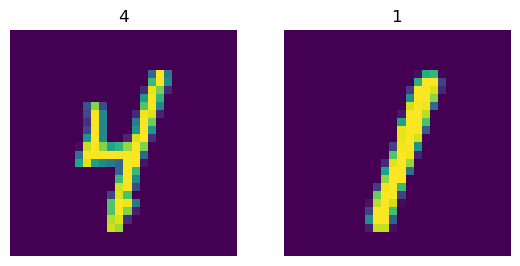

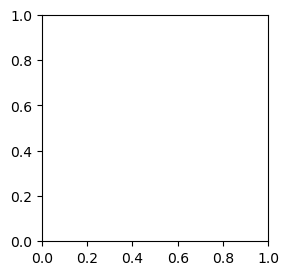

In [19]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


class ExampleAugmentation:
    def __init__(self, logdir: str, max_images: int, name: str):
        self.file_writer = tf.summary.create_file_writer(logdir)
        self.max_images: int = max_images
        self.name: str = name
        self._counter: int = 0

    def __call__(self, image, label):
        augmented_image = tf.image.random_flip_left_right(
            tf.image.random_flip_up_down(image)
        )
        with self.file_writer.as_default():
            tf.summary.image(
                self.name,
                augmented_image,
                step=self._counter,
                max_outputs=self.max_images,
            )

        self._counter += 1
        return augmented_image, label


if __name__ == "__main__":

    # Global settings

    BATCH_SIZE = 32
    DATASET_SIZE = 60000
    EPOCHS = 5

    LOG_DIR = "."
    AUGMENTATION = ExampleAugmentation(LOG_DIR, max_images=4, name="Images")

    # Dataset

    dataset = tfds.load("mnist", as_supervised=True, split=tfds.Split.TRAIN)
    # tfds.show_examples(train_ds,metadata)
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(2)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title(int(label))
        plt.axis("off")

    dataset = (
        dataset.map(
            lambda image, label: (
                tf.image.convert_image_dtype(image, dtype=tf.float32),
                label,
            )
        )
        .batch(BATCH_SIZE)
        .map(AUGMENTATION)
        .repeat(EPOCHS)
    )

    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(2)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title(int(label))
        plt.axis("off")


    # Model and training

    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(10, activation="softmax"),
        ]
    )

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

    # model.fit(
    #     dataset,
    #     epochs=EPOCHS,
    #     steps_per_epoch=DATASET_SIZE // BATCH_SIZE,
    #     callbacks=[tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR)],
    # )